# Sprawodzanie - mnożenie macierzy

Kod i wykonanie: Sebastian Kaczor

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Opis maszyny

Parametry komputera którego używałem do obliczeń:

* Procesor Intel Core i7-7700
   * 4 rdzenie
   * 4 GHz
   * Hyper threading wyłączony
   * Cache
       * 32KB L1 Data + 32KB L1 Instruction
       * 256KB L2 
       * 8 MB L3 (współdzielona pomiędzy rdzeniami)
       * 64B cache line
* 16GB RAM DDR4
    * Rozmiar strony 4KB
    * Data TLB L1: 64 items (na rdzeń)
    * Data TLB L2: 1536 items (współdzielone)
* NVIDIA GeForce 1080 Ti
    * Pamięć 11 GB GDDR5X
    * 28 SM
    * 3584 Rdzeni CUDA (128/SM)

# CPU

## Analiza szybkości

In [18]:
data = pd.read_csv("Dane.csv",index_col=None)

In [19]:
data.columns

Index(['Algorithm', 'Size', 'Total bytes', 'Total time[us]', 'Tests',
       'Time per test', 'Time per elem'],
      dtype='object')

In [20]:
data.head()

,Algorithm,Size,Total bytes,Total time[us],Tests,Time per test,Time per elem
0,JKI,1,12,13.17230,16777216,7.851310e-07,7.851310e-07
1,IKJ,1,12,13.06220,16777216,7.785700e-07,7.785700e-07
2,IJK,1,12,0.03776,16777216,2.250690e-09,2.250690e-09
3,JKI,1,12,8.60158,11863283,7.250590e-07,7.250590e-07
4,IKJ,1,12,8.91937,11863283,7.518470e-07,7.518470e-07


In [21]:
data_ijk = data.loc[data['Algorithm']=='IJK']
data_jki = data.loc[data['Algorithm']=='JKI']
data_ikj = data.loc[data['Algorithm']=='IKJ']

### Czas operacji w zależności do rozmiaru boku macierzy

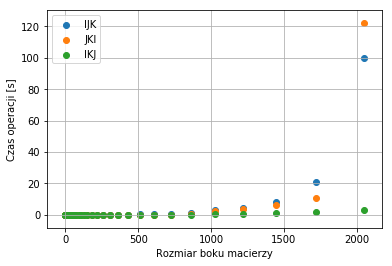

In [22]:
plt.grid(True)
plt.xlabel("Rozmiar boku macierzy")
plt.ylabel("Czas operacji [s]")
plt.scatter(data_ijk['Size'], data_ijk['Time per test'], label="IJK")
plt.scatter(data_jki['Size'], data_jki['Time per test'], label="JKI")
plt.scatter(data_ikj['Size'], data_ikj['Time per test'], label="IKJ")
plt.legend()

### Czas operacji w przeliczeniu na element

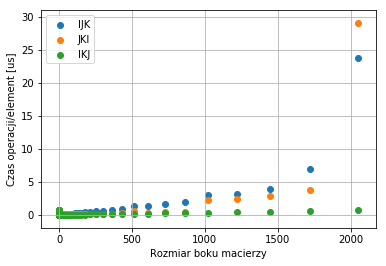

In [23]:
plt.grid(True)
plt.xlabel("Rozmiar boku macierzy")
plt.ylabel("Czas operacji/element [us]")
plt.scatter(data_ijk['Size'], data_ijk['Time per elem']*1e6, label="IJK")
plt.scatter(data_jki['Size'], data_jki['Time per elem']*1e6, label="JKI")
plt.scatter(data_ikj['Size'], data_ikj['Time per elem']*1e6, label="IKJ")
plt.legend()

## To samo, bez ostatniego rozmiaru

### Czas operacji w zależności do rozmiaru boku macierzy

In [24]:
data_ijk_filtered = data_ijk[:-1] 
data_jki_filtered = data_jki[:-1] 
data_ikj_filtered = data_ikj[:-1] 

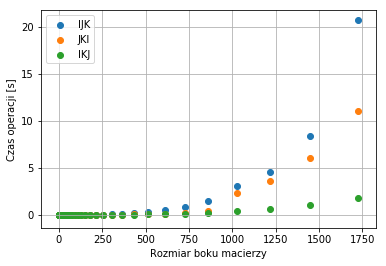

In [25]:
plt.grid(True)
plt.xlabel("Rozmiar boku macierzy")
plt.ylabel("Czas operacji [s]")
plt.scatter(data_ijk_filtered['Size'], data_ijk_filtered['Time per test'], label="IJK")
plt.scatter(data_jki_filtered['Size'], data_jki_filtered['Time per test'], label="JKI")
plt.scatter(data_ikj_filtered['Size'], data_ikj_filtered['Time per test'], label="IKJ")
plt.legend()

### Czas operacji w przeliczeniu na element

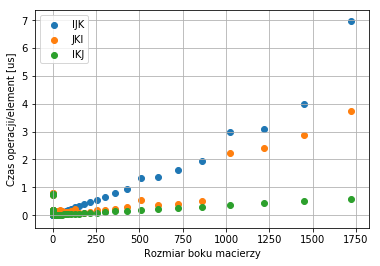

In [26]:
plt.grid(True)
plt.xlabel("Rozmiar boku macierzy")
plt.ylabel("Czas operacji/element [us]")
plt.scatter(data_ijk_filtered['Size'], data_ijk_filtered['Time per elem']*1e6, label="IJK")
plt.scatter(data_jki_filtered['Size'], data_jki_filtered['Time per elem']*1e6, label="JKI")
plt.scatter(data_ikj_filtered['Size'], data_ikj_filtered['Time per elem']*1e6, label="IKJ")
plt.legend()

## Analiza maksymalnych osiągnięć

### Minimalny czas operacji/element

In [27]:
data.loc[data['Time per elem'].idxmin()]

Algorithm                 IJK
Size                        1
Total bytes                12
Total time[us]      0.0188772
Tests                 8388607
Time per test     2.25033e-09
Time per elem     2.25033e-09
Name: 8, dtype: object

Najszybciej wykonało się mnożenie pojedyńczego elementu na jednym wątku. Nie ma w tym nic dziwnego, najprawdopodobniej element ten został raz załadowany do rejestrów CPU, więc obliczenia z jego użyciem były bardzo szybkie. Nie ma też żadnego narzutu ze strony wielowątkowości.<br><br>
Właściwie to nie interesuje nas najszybciej obliczony output, ale najwięcej obliczeń w danym czasie, więc trzeba uwzględnić również ilość obliczeń konieczną do wyliczenia jednego elementu.

### Ilość operacji na sekundę

In [41]:
data['Ops per output'] = data['Size']*2
data['Ops per second'] = data['Ops per output']/data['Time per elem']

data1 = data.sort_values('Ops per second', ascending=False)
data1.head(10)

,Algorithm,Size,Total bytes,Total time[us],Tests,Time per test,Time per elem,Ops per output,Ops per second,Parallel speedup
124,IKJ,1218,17802288,6.87501,11,0.625001,4.212950e-07,2436,5.782172e+09,7.383947
133,IKJ,2048,50331648,8.91374,3,2.971250,7.084000e-07,4096,5.782044e+09,33.508329
121,IKJ,1024,12582912,5.58512,15,0.372341,3.550930e-07,2048,5.767503e+09,8.397772
130,IKJ,1722,35583408,8.85893,5,1.771790,5.975100e-07,3444,5.763920e+09,11.688206
118,IKJ,861,8895852,4.88794,22,0.222179,2.997070e-07,1722,5.745612e+09,6.524506
127,IKJ,1448,25160448,7.40948,7,1.058500,5.048390e-07,2896,5.736482e+09,7.886633
115,IKJ,724,6290112,4.12074,31,0.132927,2.535930e-07,1448,5.709937e+09,6.379474
106,IKJ,431,2229132,2.55925,90,0.028436,1.530790e-07,862,5.631079e+09,6.228111
109,IKJ,512,3145728,3.00899,63,0.047762,1.821960e-07,1024,5.620321e+09,7.370140
94,IKJ,215,554700,1.31418,362,0.003630,7.853610e-08,430,5.475189e+09,5.950792


In [44]:
data1[data['Algorithm']=='JKI']

c:\users\sebas\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Algorithm,Size,Total bytes,Total time[us],Tests,Time per test,Time per elem,Ops per output,Ops per second,Parallel speedup
90,JKI,181,393132,1.402260,511,2.744150e-03,8.376260e-08,362,4.321738e+09,4.696989
87,JKI,152,277248,1.249720,724,1.726130e-03,7.471150e-08,304,4.068985e+09,4.398935
93,JKI,215,554700,1.793480,362,4.954380e-03,1.071800e-07,430,4.011943e+09,4.360440
102,JKI,362,1572528,3.411030,127,2.685850e-02,2.049580e-07,724,3.532431e+09,3.880053
111,JKI,609,4450572,5.819270,45,1.293170e-01,3.486750e-07,1218,3.493224e+09,3.907220
114,JKI,724,6290112,6.800450,31,2.193690e-01,4.185030e-07,1448,3.459951e+09,3.865659
117,JKI,861,8895852,8.166730,22,3.712150e-01,5.007480e-07,1722,3.438855e+09,3.905038
99,JKI,304,1108992,2.996230,181,1.655370e-02,1.791220e-07,608,3.394335e+09,3.728827
105,JKI,431,2229132,4.952480,90,5.502750e-02,2.962280e-07,862,2.909921e+09,3.218443
96,JKI,256,786432,3.327160,255,1.304770e-02,1.990920e-07,512,2.571675e+09,2.825653


Duże macierze pozwalają w pełni wykorzystać potencjał zrównoleglania. Algorytm IKJ jest zdecydowanie jest zdecydowanie szybszy.

Liczba instrukcji na sekundę (2\*n instrukcji na element: mnożenie i akumulacja) GFLOPS:

In [29]:
fastest = float(data1.head(1)['Ops per second']/1e9)
fastest

5.782171637451192

Dla analogicznego rozmiaru macierzy algorytm sekwencyjny uzyskuje:

In [30]:
iterative_for_fastest = float(data1[(data1['Algorithm'] == "IJK") & (data1['Size']==1218)]['Ops per second']/1e9)
iterative_for_fastest

0.7830732732848574

In [31]:
print("Co daje {}x przyśpieszenia".format(fastest/iterative_for_fastest))

Co daje 7.383947115441673x przyśpieszenia


In [32]:
del data1

## Porównanie przyśpieszenia

In [33]:
iterative_speeds = data[data['Algorithm']=='IJK']['Time per elem']
iterative_speeds = np.tile(iterative_speeds.values, (3,1)).swapaxes(0,1).reshape((-1))#repeat each element 3 times
data['Parallel speedup'] = iterative_speeds/data['Time per elem']

data_speedup_sorted = data[data['Algorithm']!='IJK'].sort_values('Parallel speedup')

### Najgorsze przyśpieszenie
Dla poniższy rozmiarów nie ma sensu używać algorytów równoleglych, ponieważ powodują spadek szybkości przetwarzania

In [34]:
data_speedup_sorted.head(20)

,Algorithm,Size,Total bytes,Total time[us],Tests,Time per test,Time per elem,Ops per output,Ops per second,Parallel speedup
6,JKI,1,12,6.615810,8388607,7.886660e-07,7.886660e-07,2,2.535928e+06,0.002853
0,JKI,1,12,13.172300,16777216,7.851310e-07,7.851310e-07,2,2.547346e+06,0.002867
1,IKJ,1,12,13.062200,16777216,7.785700e-07,7.785700e-07,2,2.568812e+06,0.002891
4,IKJ,1,12,8.919370,11863283,7.518470e-07,7.518470e-07,2,2.660116e+06,0.002995
7,IKJ,1,12,6.167200,8388607,7.351880e-07,7.351880e-07,2,2.720393e+06,0.003061
3,JKI,1,12,8.601580,11863283,7.250590e-07,7.250590e-07,2,2.758396e+06,0.003106
15,JKI,2,48,2.357230,2965820,7.948000e-07,1.987000e-07,4,2.013085e+07,0.016354
13,IKJ,2,48,3.297770,4194303,7.862510e-07,1.965630e-07,4,2.034971e+07,0.016521
16,IKJ,2,48,2.332520,2965820,7.864690e-07,1.966170e-07,4,2.034412e+07,0.016527
12,JKI,2,48,3.286300,4194303,7.835150e-07,1.958790e-07,4,2.042077e+07,0.016579


### Najlepsze przyśpieszenie

In [35]:
data_speedup_sorted.tail(10)

,Algorithm,Size,Total bytes,Total time[us],Tests,Time per test,Time per elem,Ops per output,Ops per second,Parallel speedup
112,IKJ,609,4450572,3.74369,45,0.083193,2.243120e-07,1218,5.429937e+09,6.073460
106,IKJ,431,2229132,2.55925,90,0.028436,1.530790e-07,862,5.631079e+09,6.228111
115,IKJ,724,6290112,4.12074,31,0.132927,2.535930e-07,1448,5.709937e+09,6.379474
118,IKJ,861,8895852,4.88794,22,0.222179,2.997070e-07,1722,5.745612e+09,6.524506
109,IKJ,512,3145728,3.00899,63,0.047762,1.821960e-07,1024,5.620321e+09,7.370140
124,IKJ,1218,17802288,6.87501,11,0.625001,4.212950e-07,2436,5.782172e+09,7.383947
127,IKJ,1448,25160448,7.40948,7,1.058500,5.048390e-07,2896,5.736482e+09,7.886633
121,IKJ,1024,12582912,5.58512,15,0.372341,3.550930e-07,2048,5.767503e+09,8.397772
130,IKJ,1722,35583408,8.85893,5,1.771790,5.975100e-07,3444,5.763920e+09,11.688206
133,IKJ,2048,50331648,8.91374,3,2.971250,7.084000e-07,4096,5.782044e+09,33.508329


Algorytm IKJ definitywnie dominuje nad metodami iteracyjnymi dla dużych macierzy. Im większa macierz tym większy zysk.

## Inne analizy
Macierze wejściowe A,B<br>
Macierz wyjściowa C<br>
Wszystkie rozmiarów NxN<br>

### Algorytm IKJ
Każdy wątek zajmuje się tworzeniem jednego rzędu macierzy wyjściowej.<br>
Pamięć czytana jest liniowo zarówno z macierzy A jak i B. <br>
Macierz C również jest czytana/zapisywania liniowo, ale każdy rząd zostanie odczytany/zapisany N razy.<br>
Macierze C i B są czytane wielokrotnie, co powoduje brak lokalności czasowej.

### Algorytm JKI
Każdy wątek zajmuje się tworzeniem jednej kolumny macierzy wyjściowej.<br>
Macierz A nie jest czytana liniowo (jest czytana po kolumnach, czyli w skokach o N \* sizeof(float) bajtów). Pamieć B również nie jest czytania liniowo, ale jej odczyty dzieje się raz na N mnożeń, więc nie wprowadza to znaczących kosztów.<br>
Macierz C również nie jest zapisywana/oczytywania liniowo. W każdej iteracji najbardziej wewnętrznej pętli aktualizowany jest kolejny element kolumny, co powoduje skok o N \* sizeof(flaot) bajtów.<br>
Macierze C i A są czytane wielokrotnie, co może powodować brak lokalności czasowej.<br>
Macierze C i A są czytane skokowo, co może powodować brak lokalności przestrzennej.


### Analiza warunków lokalnego czasowo dostępu do danych w pamięci podręcznej
L3 na moim systemie ma rozmiar 8MB<br>
Potrzeba załadować 2 macierze (czytane wielokrotnie) -> 8MB/2 = 4MB na macierz<br>
Float ma 4B -> 4MB/4B = 1048576 elementów<br>
Rozmiar boku macierzy: $\sqrt{1048576}$ = 1024<br>
Powyżej tego rozmiaru lokalność czasowa nie jest zapewniona w obu metodach

### Analiza warunków lokalnego przestrzennie dostępu do danych (tylko JKI)
64 wpisy \* 4 KB (strona) = 256KB  ->  128KB na macierz  -> 32768 elementów na macierz -> 181 rozmiar boku<br>
1536 wpisów \* 4 KB (strona) = 6MB<br>
6MB + 256KB = 6400KB -> 3200 KB na macierz -> 819200 elementów na macierz -> 905 rozmiar boku<br>
<br>
Powyżej 256KB (n=181) lokalność przestrzenna, korzystając tylko z L1 TLB, nie jest zapewniona<br>
Powyżej 6.25MB (n=905) lokalność przestrzenna nie jest zapewniona, nawet z użyciem L2TLB



### Analiza obciążenia
Problem: nawet przy macierzach 1 elementowych wszystkie rdzenie są wykorzystywane
![Obciążenie](img/1elem4cores.png)

Zamiast mierzyć równomiernosć obciążenia postanowiłem wyznaczyć minimalny rozmiar instancji, który pozwala na wydajne zrównologlenie (50% optymalnego przy 4 rdzeniach)



## Analiza wydajności zrównoleglania

In [36]:
data2 = pd.read_csv("Dane2.csv")
data2.columns

Index(['Algorithm', 'Size', 'Total bytes', 'Time[us]', 'Tests', 'Num threads'], dtype='object')

### Tabela zbiorcza wyników

In [39]:
data2.groupby(['Algorithm', 'Size', 'Num threads']).min()

Total bytes  Time[us]    Tests
Algorithm Size Num threads                                
IKJ       2    1                     48    172895  4194304
               2                     48   1260571  4194304
          16   1                   3072    725398   131072
               4                   3072    305929   131072
          32   1                  12288    711222    16384
               4                  12288    227411    16384
          64   1                  49152    703866     2048
               4                  49152    189822     2048
          128  1                 196608    728826      256
               4                 196608    203452      256
          256  1                 786432    725945       32
               4                 786432    205136       32
JKI       16   1                   3072    763465   131072
               4                   3072   4377061   131072
          64   1                  49152    800784     2048
               4                  49152   1096942     2048
          128  1                 196608    961299      256
               4                 196608    884738      256
          256  1                 786432   1276323       32
               4                 786432    441655       32

Tabelka przedstawia czasy mnożenia macierzy o rozmiarach 'size' 'test's razy. Ilość testów została dopasowana do rozmiaru, aby zapewnić czas wykonywania niezależny od rozmiaru (choć nie ma to większego wpływu na analizę).

### Efektywność paralelizacji

In [43]:
data2 = data2.groupby(['Algorithm', 'Size', 'Num threads'], as_index=False).mean()
data2['Time per core'] = data2['Time[us]'] * data2['Num threads']
multi_threaded = data2.loc[data2['Num threads'] > 1].copy()
single_threaded = data2.loc[data2['Num threads'] == 1].copy()
multi_threaded['Efficiency'] = single_threaded['Time per core'].values/multi_threaded['Time per core'].values
multi_threaded[['Algorithm', 'Size', 'Num threads', 'Efficiency']]

,Algorithm,Size,Num threads,Efficiency
1,IKJ,2,2,0.066712
3,IKJ,16,4,0.527814
5,IKJ,32,4,0.667287
7,IKJ,64,4,0.863842
9,IKJ,128,4,0.851466
11,IKJ,256,4,0.820523
13,JKI,16,4,0.043613
15,JKI,64,4,0.183335
17,JKI,128,4,0.270596
19,JKI,256,4,0.707360


Wyjaśnienie:<br>
Wydajność (efficiency) na poziomie 1/liczba wątków oznacza, że wprowadzenie wielowątkowości nie przyśpieszyło programu<br>
Wydajność mniejsza niż 1/liczba wątków oznacza, że wielowątkowość spowolniła działanie programu<br>
Wydajność bliska 1 oznacza przyśpieszenie bliskie teoretycznemu maksimum<br>
Wydajność = Przyśpieszenie/Liczba wątków

* Algorytm IKJ osiąga zadowalający poziom paralelizacji już przy macierzach o rozmiarze 16
* Algorytm JKI potrzebuje macierzy do tego macierzy o rozmiarze 128-256

## Podsumowanie
Algorytm IKJ jest zdecydowanie szybszy niż algorytm JKI. <br>
Wynika to z znacznie lepszej lokalności przestrzennej. IKJ czyta wszystkie macierze liniowo, bez żadnych skoków. JKI Czyta dwie macierze skokowo, a na dodatek jedną z nich czyta w ten sposób wielokrotnie. Oznacza to że wzrost rozmiaru macierzy powoduje dla algorytmu JKI coraz większe spowolnienia wynikające z coraz gorszej przestrzennej lokalności (adresy macierzy przestają się mieścić w TBL, więc trzba wykonywać wieloetapowe przeliczanie adresu wirtualnego na rzeczywisty).<br> Dodatkowo wczytywanie skokowe algorytmu JKI powoduje zmarnowanie większości danych wczytanych z linii pamięci cache (używamy tylko 1 floata, czyli 4 bajtów, a wczytujemy 64b), podczas gdy IKJ w dwóch najczęściej czytanych macierzach korzysta w pełni z linii cache.

# GPU

## Analiza ilości dostępów do pamięci dla GPU

#### Założenia
* Załóżmy rozmiar boku macierzy: n
* Założmy rozmiar bloku: b
* Każdy wątek oblicza 2 elementy
* Każdy blok oblicza b\*b*2 elementów

Ilość bloków w macierzy wyjściowej: n/b x n/(2\*b)<br>
Ilość odczytywanych bloków potrzebnych do wyliczenia jednego bloku wyjściowego:  n/b lub n/(2*b)<br>
Ilość elementów odczytywanych przez blok = ilość wątków w bloku<br>
Odczytywane są 2 macierze

$$({n \over b} * {n \over 2b}) * ( {n \over b} + {n \over 2b} ) * (b*b*2)  =  {n^3 \over b} * (1  + {1 \over 2} )$$

In [223]:
def reads_blocked(n, b):
    from math import ceil
    return ceil(n/b) * ceil(n/2/b) * ( ceil(n/b) + ceil(n/2/b) ) * b * b * 2
def reads_naive(n):
    return n**3

def gcma(n, reads = None):
    if not reads:
        reads = n**3
    return n**3*2/reads

Przykładowo dla macierzy o rozmiarze 512 i bloku o rozmiarze 32

In [231]:
n = 512
b = 32
reads_blocked_val = reads_blocked(n, b)
reads_naive_val = reads_naive(n)
print("Blokowo {}, bez bloków {}, oszczędność {:.4f}".format(reads_blocked_val, reads_naive_val, reads_naive_val/reads_blocked_val))

Blokowo 6291456, bez bloków 134217728, oszczędność 21.3333


Oszczędność odczytów przekłada się bezpośrednio na ilość dostępów do pamięci globalnej.

In [232]:
print("CGMA blokowo {:.4f}, bez bloków {:.4f}".format(gcma(n,reads_blocked(n,b)), gcma(n)))

GCMA blokowo 42.6667, bez bloków 2.0000


### Szybkość przetwarzania GPU

In [238]:
data3 = pd.read_csv("Dane3.csv")
data3["Time per test"] = data3['Time']/data3['Iters']
data3["Time per elem"] = data3["Time per test"]/data3['Size']**2
data3['Ops per second'] = 1/data3['Time per elem']*2*data3['Size']
data3.sort_values('Block size', inplace=True)
data3

,Size,Block size,Iters,Time,Time per test,Time per elem,Ops per second
4,4096,8,20,16.05000,0.802500,4.783273e-08,1.712635e+11
8,2048,8,100,9.62773,0.096277,2.295430e-08,1.784415e+11
3,4096,16,20,6.87242,0.343621,2.048141e-08,3.999725e+11
7,2048,16,100,4.21795,0.042180,1.005638e-08,4.073038e+11
1,4096,30,20,3.59133,0.179567,1.070300e-08,7.653931e+11
0,4096,32,20,3.21624,0.160812,9.585142e-09,8.546561e+11
2,4096,32,100,16.08440,0.160844,9.587049e-09,8.544860e+11
5,8192,32,20,25.60860,1.280430,1.907989e-08,8.587050e+11
6,2048,32,100,2.04758,0.020476,4.881811e-09,8.390329e+11


### Maksymalna ilość operacji

In [240]:
gpu_max_ops = np.max(data3['Ops per second'].values)
print("Maksymalna wydajność {:.3f} GFLOPS".format((gpu_max_ops*1e-9)))

Maksymalna wydajność 858.705 GFLOPS


Maksymalna wydajność deklarowana przez Nvidię to 11 000 GFLOPS, ale wymaga ona korzystania z Fused Multiply Add, co nie było częścią tego zadania.

### Zajętość multiprocesora
50% - Wynik z kalkulatora CUDA (1024 (32x32) wątki na blok, 8GB pamięci współdzielonej, 22 rejestry).<br>
Ograniczeniem prawdopodobnie była ilość rejestrów używana przez wątki.<br>
<br>
Rozmiar bloku 30x30 był sugerowany przez kalkulator jako zapewniający większą zajętość multiprocesora. Nie przełożyło się to jednak na poprawę wydajności.

![ZajetoscGPU](img/gpu.png)
Zajętość procesora GPU podczas mnożenia macierzy 8192x8192 100 razy.